In [ ]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
EXAMPLE_NAME = os.path.basename(EXAMPLE_DIR)
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

# jupyter-notebook --notebook-dir=$PWD --port=8889 --ip=0.0.0.0

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import gym
import time
import numpy as np
import networkx as nx
from typing import List
from collections import defaultdict

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis.multiobjective_solver import MultiObjectiveSolver
from src.graph.trans_sys import FiniteTransSys
from src.spot.Parser import ANDExpression, SymbolExpression, NotSymbolExpression, TrueExpression
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, GYM_MONITOR_LOG_DIR_NAME, BoxPacking

Graph.graph_dir = EXAMPLE_DIR

In [ ]:
debug = True

dfa_config_yaml="config/DFA"
pdfa_config_yaml="config/PDFA"
strategy_config_yaml="config/Strategy"

# Graph Arguments
load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

# Multi-Objective Optimizer Arguments
stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

NUM_OBJ = 3
PLAYER_MAPPING = {'eve': 'sys', 'adam': 'env'}

ROS_PACKAGE_DIR = os.path.join(PROJECT_DIR, '..')
STRATEGY_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'strategy.pickle')
LOCATION_MAPPINGS_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'location_mappings.pickle')

ADD_SYS_WEIGHT = True
ADD_ENV_WEIGHT = True

NUM_LOCATION = 3

ENV_ID = 'MiniGrid-Franka-BoxPacking-v0'



# Define a Franka environment

In [ ]:
locations = ['L0', 'L1', 'L2', 'L3']
object_locations = {
    'o0': 'L0', 
    'o1': 'L1', 
    'o2': 'L2'}
target_locations = ['L3', 'L3', 'L3']

location_mappings = {
    'H':  np.array([  0,   0, 0.1]),
    'L0': np.array([0.7, 0.7, 0.1]),
    'L1': np.array([0.3, 0.3, 0.1]),
    'L2': np.array([0.1, 0.1, 0.1]),
    'L3': np.array([0.3, -0.3, 0.1]),
}

world_config_kwargs = {
    'locations': locations,
    'object_locations': object_locations,
    'target_locations': target_locations,
    'distance_mappings': BoxPacking.locations_to_distance_mappings(location_mappings)
}

env = gym.make(ENV_ID, **world_config_kwargs)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps={'sys': [1], 'env': [1]},
        monitor_log_location=os.path.join(EXAMPLE_DIR, GYM_MONITOR_LOG_DIR_NAME))

In [15]:
file_name = ENV_ID + 'Game'
filepath = os.path.join(EXAMPLE_DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
trans_sys = graph_factory.get('TwoPlayerGraph',
                              graph_name='TwoPlayerGame',
                              config_yaml=config_yaml,
                              minigrid=env,
                              save_flag=save_flag,
                              plot=plot_minigrid,
                              view=view,
                              format=format)
end = time.time()

In [16]:
# init_node = trans_sys.get_initial_states()[0][0]
# # trans_sys.plot_graph(format=format, view=False, start_node=init_node, n_neighbor=10)
# trans_sys.plot_graph(format=format, view=False)

# Construct DFA and Manually Specify PDFA from DFA 



In [18]:
# def count_true_symbols(formula):
#     if isinstance(formula, (TrueExpression, NotSymbolExpression)):
#         return 0
#     elif isinstance(formula, SymbolExpression):
#         return 1
#     elif isinstance(formula, ANDExpression):
#         return count_true_symbols(formula.left) + count_true_symbols(formula.right)
#     else:
#         raise Exception(f'Expression type {type(formula)} not implemented')

# def delete_unnecessary_edges(dfa):
#     edges_to_delete = []
#     for u, v, attr in dfa._graph.edges.data():
#         # Delte if edges have multiple true symbols
#         if count_true_symbols(attr['guard']) > 1:
#             edges_to_delete.append((u, v))

#     for u, v in edges_to_delete:
#         dfa._graph.remove_edge(u, v)

#     return dfa

# dfa = delete_unnecessary_edges(dfa)
# # dfa.plot_graph(view=view, format=format)
# dfa.dump_to_yaml(export_to_pdfa=True)

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing_extended/plots/pdfa.png


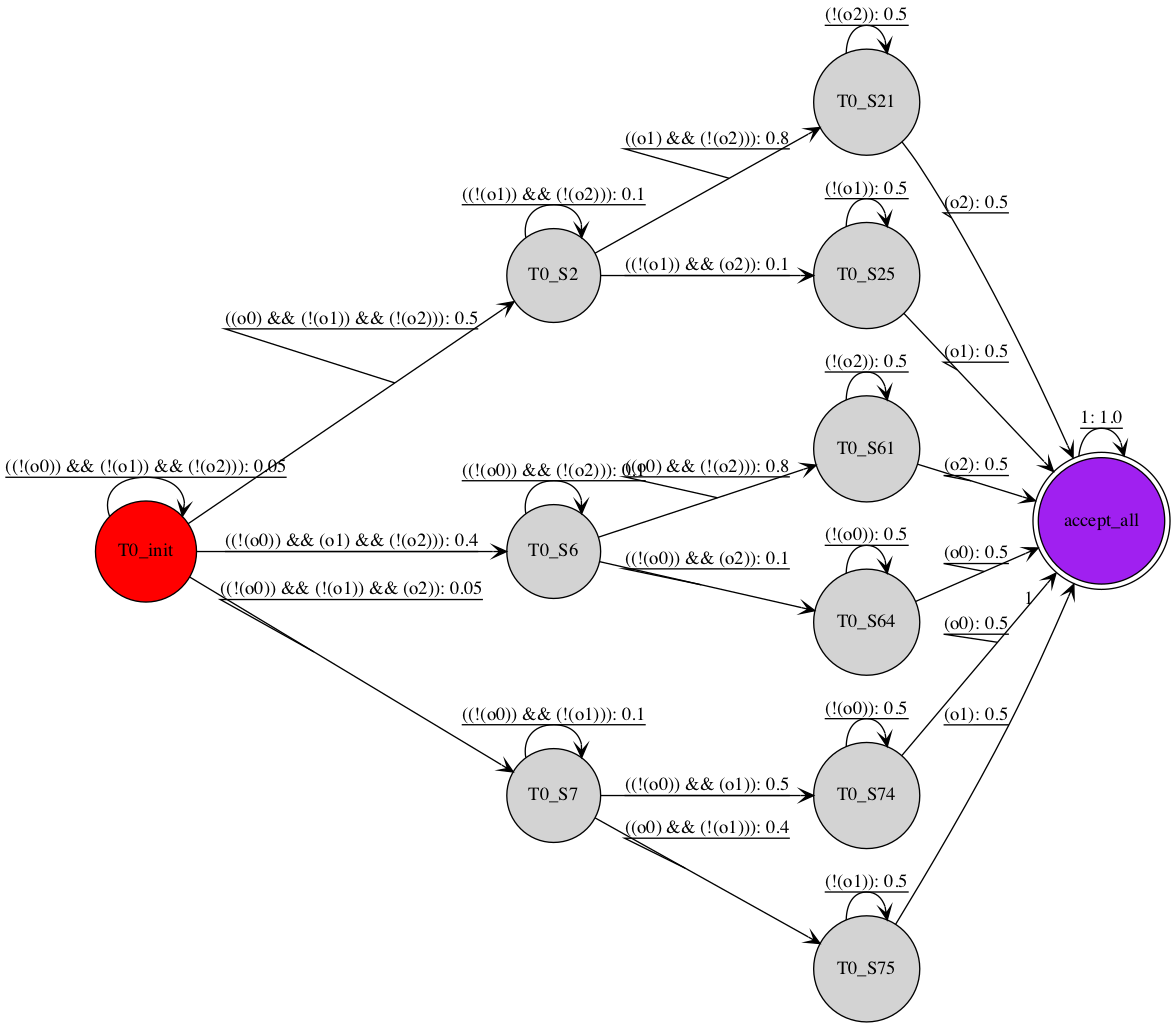

In [13]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

# Manually Define Game
Given a list of objects, construct a product graph


In [19]:
# Product Game Construction
start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name=f'{EXAMPLE_NAME}_ProductAutomaton',
    config_yaml=None,
    trans_sys=trans_sys,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 29.14 seconds


In [20]:
# game.plot_graph(view=view, format=format)

In [22]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

136308 nodes and 312796 edges
1th Iteration took 2704.12 seconds
2th Iteration took 3483.61 seconds
3th Iteration took 3095.35 seconds


KeyboardInterrupt: 

In [ ]:
# strategies = solver.get_strategies()
# strategy = list(strategies.values())[0]
# strategy._config_yaml = "config/Strategy"
# strategy.plot_graph(view=view, format=format, save_yaml=True)

for strategy in list(solver.get_strategies().values()):
    strategy._config_yaml = "config/Strategy"
    strategy.plot_graph(view=False, format=format)